#pip

In [1]:
!unzip /content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/open.zip #약 10분

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train_img/TRAIN_2140.png  
  inflating: train_img/TRAIN_2141.png  
  inflating: train_img/TRAIN_2142.png  
  inflating: train_img/TRAIN_2143.png  
  inflating: train_img/TRAIN_2144.png  
  inflating: train_img/TRAIN_2145.png  
  inflating: train_img/TRAIN_2146.png  
  inflating: train_img/TRAIN_2147.png  
  inflating: train_img/TRAIN_2148.png  
  inflating: train_img/TRAIN_2149.png  
  inflating: train_img/TRAIN_2150.png  
  inflating: train_img/TRAIN_2151.png  
  inflating: train_img/TRAIN_2152.png  
  inflating: train_img/TRAIN_2153.png  
  inflating: train_img/TRAIN_2154.png  
  inflating: train_img/TRAIN_2155.png  
  inflating: train_img/TRAIN_2156.png  
  inflating: train_img/TRAIN_2157.png  
  inflating: train_img/TRAIN_2158.png  
  inflating: train_img/TRAIN_2159.png  
  inflating: train_img/TRAIN_2160.png  
  inflating: train_img/TRAIN_2161.png  
  inflating: train_img/TRAIN_2162.png  
  inflating: train_img/TRAIN_2163.png  
  in

In [2]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=e5bb09e91ef745acf2107af99e6d6b3fdc491908a9ccd00d59507f2271049d89
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=5e3f0ff9d126bb584497a910e56a7ec06ecd3df2e6eb3d2cf9b4e58f2b5bdb6d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter

from PIL import Image,ImageFile
import albumentations as A
import matplotlib.pyplot as plt

from sklearn import model_selection
import segmentation_models_pytorch as smp

import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

ImageFile.LOAD_TRUNCATED_IMAGES = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#metric func

In [4]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

#calculate loss

In [5]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    #prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    #prediction_df.index = range(prediction_df.shape[0])


    # Extract the mask_rle columns
    #pred_mask_rle = prediction_df.iloc[:, 1]
    #gt_mask_rle = ground_truth_df.iloc[:, 1]
    pred_mask_rle = prediction_df
    gt_mask_rle = ground_truth_df


    def calculate_dice(pred_rle, gt_rle):
        #pred_mask = rle_decode(pred_rle, img_shape)
        #gt_mask = rle_decode(gt_rle, img_shape)
        pred_mask = pred_rle
        gt_mask = gt_rle

        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

#model dataset/transform

In [6]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomCrop, Compose
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # 좌우 대칭
        A.VerticalFlip(p=0.5),    # 상하 대칭
        #A.Rotate(limit=180, p=0.5),  # 90도 회전
        #A.RandomResizedCrop(224,224,scale=(0.17,0.27),ratio=(1.0,1.0)), #0.22 -> 1024 -> 224
        A.RandomCrop(224,224),
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)
vali_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # 좌우 대칭
        A.VerticalFlip(p=0.5),    # 상하 대칭
        A.RandomCrop(224,224),
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)


class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, is_validation=False, is_test=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.is_validation = is_validation
        if(is_test):
          pass
        elif(self.is_validation):
          self.data = self.data[:100]
        else:
          self.data = self.data[100:]

    def __len__(self):
        if(self.is_validation):
          return 5*len(self.data)
        else:
          return len(self.data)

    def __getitem__(self, idx):

        if(self.is_validation):
          idx = idx % len(self.data)

        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform: #infer는 test_transform으로
                image = test_transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
          if self.is_validation:
            augmented = vali_transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
          else:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [7]:
def denoramlize(img):
    img = img.permute(1,2,0)            # change shape ---> (width, height, channel)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    img = img*std + mean
    img = np.clip(img,0,1)              # convert the pixel values range(min=0, max=1)
    return img

def imshow(img, mask):
    fig = plt.figure(figsize=(15, 10))
    a = fig.add_subplot(1, 3, 1)
    plt.imshow(denoramlize(img), cmap='bone')
    a.set_title("Original image")
    plt.grid(False)
    plt.axis("off")

    if(mask!=None):
      a = fig.add_subplot(1, 3, 2)
      imgplot = plt.imshow(mask, cmap='binary')
      a.set_title("The mask")
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])

      plt.axis("off")
      plt.grid(False)


def show_batch_image(dataloader, num_images,is_vali):
    data = next(iter(dataloader))
    if(is_vali):
      image = data[0]
      mask = data[1]
      img_idx = torch.randint(0, batch_size, (num_images,))
      for i in img_idx:
          print(i)
          imshow(image[i], mask[i])
    else:
      image = data
      img_idx = torch.randint(0, batch_size, (num_images,))
      for i in img_idx:
          print(i)
          imshow(image[i], None)

#model main

In [8]:
Encoder = 'resnet34'
Weights = 'imagenet'

prep_fun = smp.encoders.get_preprocessing_fn(
    Encoder,
    Weights
)

#train/eval method

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def train():
    # training loop
    for epoch in range(50):  # 10 에폭 동안 학습합니다.
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        model.eval()
        vali_epoch_loss=0
        dice_score = 0
        for images, masks in tqdm(vali_dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = np.squeeze(preds, axis=1)
            preds = (preds > 0.5).astype(np.uint8) # Threshold = 0.35

            vali_epoch_loss += loss.item()

            masks = masks.detach().cpu().numpy()

            dice_score+=calculate_dice_scores(masks,preds) * len(images)


        print(f'Epoch {epoch+1}, train_Loss: {epoch_loss/len(dataloader)} vali_loss: {vali_epoch_loss/len(vali_dataloader)} dice_score: {dice_score/len(vali_dataset)}')

def vali_inference():
  with torch.no_grad():
     model.eval()
     dice_score=0
     for images, masks in tqdm(vali_dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = np.squeeze(preds, axis=1)
            preds = (preds > 0.5).astype(np.uint8) # Threshold = 0.35

            masks = masks.detach().cpu().numpy()

                        # 네프파이 배열을 이미지로 변환
        #    for i in range(len(images)):
        #      # 이미지를 파일로 저장
        #      cv2.imwrite(f"image_mask_sample_{i}.png",masks[i])
        #
        #      # 이미지를 파일로 저장
        #      cv2.imwrite(f"image_pred_sample_{i}.png",preds[i])  # 저장할 파일 이름과 확장자를 적절히 지정하세요

            dice_score+=calculate_dice_scores(masks,preds) * len(images)
     print(f"dice score for validation: {dice_score/len(vali_dataset)}")

def inference():
    with torch.no_grad():
        model.eval()
        result = []
        for images in tqdm(test_dataloader):
            images = images.float().to(device)

            outputs = model(images)
            masks = torch.sigmoid(outputs).cpu().numpy()
            masks = np.squeeze(masks, axis=1)
            masks = (masks > 0.5).astype(np.uint8) # Threshold = 0.35

            #for i in range(len(masks)):
            #  mask = masks[i]
            #  if(len(mask[mask==1])<1000):
            #    mask[mask==1]=0
            #    masks[i]=mask


            for i in range(len(images)):
                mask_rle = rle_encode(masks[i])
                if len(mask_rle.split()) < 10: # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
        submit = pd.read_csv('./sample_submission.csv')
        submit['mask_rle'] = result
        submit.to_csv(csv_loc, index=False)

#load data

In [12]:
csv_loc = '/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/residual_attention_20230711.csv'
model_name = '/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/model/unet_20230711.pt'

In [13]:
model = smp.Unet(
    encoder_name = Encoder,
    encoder_weights = Weights,
    in_channels = 3,
    classes = 1,
    activation = None
)

model.to(device)
model.load_state_dict(torch.load(model_name))

print("done")

done


In [14]:

#criterion = FocalLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = MixedLoss(alpha = 10.0,
                      gamma = 2.0)
#criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.9 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

batch_size= 64

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform, is_validation=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

vali_dataset = SatelliteDataset(csv_file='./train.csv', transform=transform,is_validation=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True,is_test=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


print(len(dataset))
print(len(vali_dataset))
print(len(test_dataset))

print()

print(len(dataloader))
print(len(vali_dataloader))
print(len(test_dataloader))

#"checking error"
dataset[1]
vali_dataset[1]
test_dataset[1]
print("dataset finished")

7040
500
60640

110
8
948
dataset finished


In [ ]:
show_batch_image(test_dataloader,5,False)

In [ ]:
show_batch_image(dataloader,5,True)

In [ ]:
num_params = sum(p.numel() for p in model.parameters())
num_params

24436369

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train()  # 모델 훈련
#모델 저장
torch.save(model.state_dict(),model_name)

In [16]:
vali_inference()

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]

dice score for validation: 0.7559524944894076


In [ ]:
inference()

100%|██████████| 948/948 [03:33<00:00,  4.45it/s]


In [ ]:
torch.save(model.state_dict(),model_name)

#dataset for checking data

In [17]:
#crop 결과 시각화를 위한 dataset
%cd /content/
class plt_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = A.Compose(
          [
              A.HorizontalFlip(p=0.5),  # 좌우 대칭
              A.VerticalFlip(p=0.5),    # 상하 대칭
              #A.Rotate(limit=180, p=0.5),  # 90도 회전
              A.RandomCrop(224,224),
              A.Resize(224, 224),
              ToTensorV2()
          ]
        )
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

plt_dataset = plt_Dataset(csv_file='./train.csv')

#crop 결과 시각화를 위한 dataset
class plt_test_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = A.Compose(
          [

              A.RandomCrop(224,224),
              A.Resize(224, 224),
              ToTensorV2()
          ]
        )
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

plt_test_dataset = plt_test_Dataset(csv_file='./test.csv',infer=True)

/content


#see data

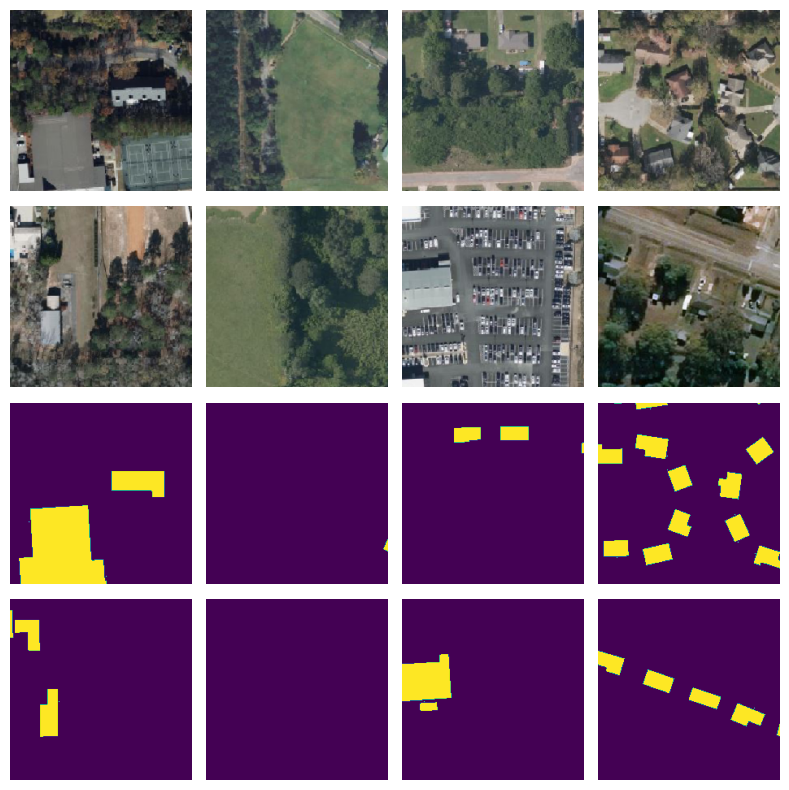

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

idx = 6400
image_see = []
mask_see = []
for i in range(idx,idx+8):
  image, mask = plt_dataset[i]
  image_see.append(image)
  mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



4818
1197
0
7578
6312
7764
3748
0


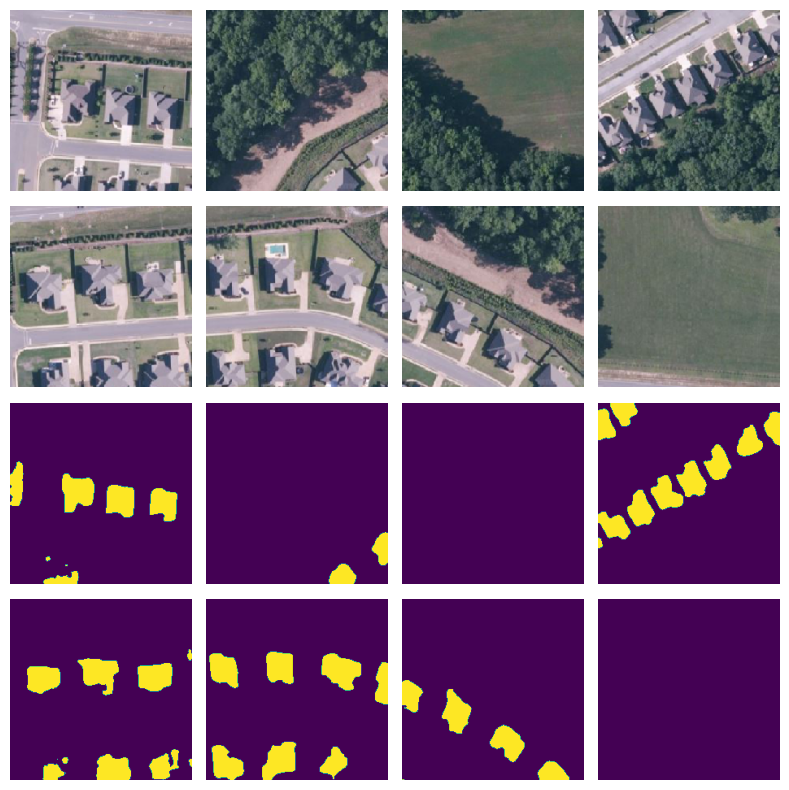

In [ ]:
comp_loc = '/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/submit_64percent.csv'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

idx = 0

image_see = []
mask_see = []

submit_csv = pd.read_csv(comp_loc)
new_submit_csv = submit_csv.copy()

for i in range(idx,idx+8):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = submit_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



0
1821
1125
639
0
464
9139
0


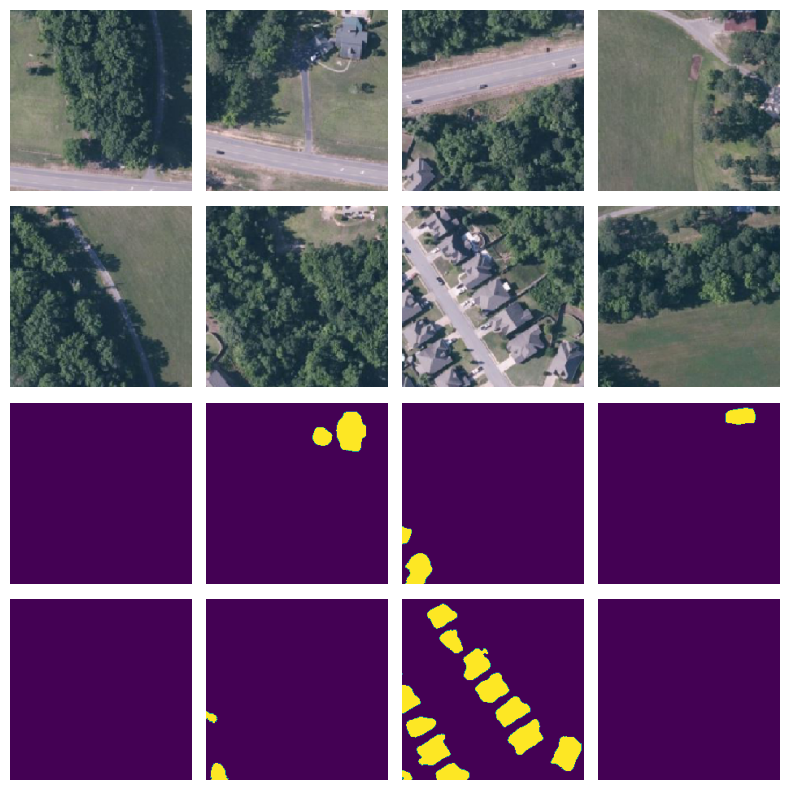

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

idx = 8

image_see = []
mask_see = []

submit_csv = pd.read_csv(csv_loc)
new_submit_csv = submit_csv.copy()

for i in range(idx,idx+8):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = submit_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



#동시비교

719
0
4383
2914

570
0
3051
2533


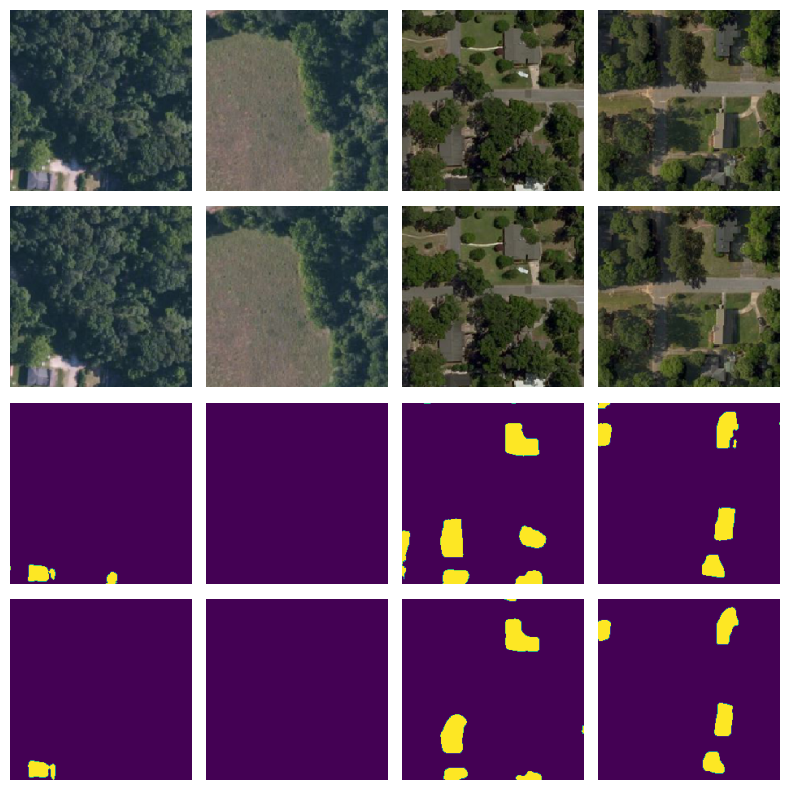

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

comp_loc = '/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/residual_attention_20230707.csv'
idx = 321

image_see = []
mask_see = []

submit_csv = pd.read_csv(csv_loc)
comp_csv = pd.read_csv(comp_loc)

new_submit_csv = submit_csv.copy()
new_comp_csv = comp_csv.copy()

for i in range(idx,idx+4):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = submit_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)

print()

for i in range(idx,idx+4):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = comp_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)


image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()

